<a href="https://colab.research.google.com/github/IgorJoaquimn/webp-compression/blob/main/TP_ICV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alunos: Igor Joaquim da Silva Costa (2021032218) e Marco Túlio de Pinho (2021031980)**


O objetivo deste trabalho é comprimir uma imagem passada como entrada. O método desenvolvido pode ser com ou sem perdas, de acordo com a [referência](https://developers.google.com/speed/webp/docs/compression).

## Definição do Pipeline de Compressão
`[macroblocks -> preditive pixel -> residuals-> transform coding DCT -> quantization -> Arithmetic entropy encoding]`

O pipeline de compressão no formato WebP segue uma série de etapas projetadas para reduzir eficientemente o tamanho dos dados da imagem.
1. Primeiramente, a imagem é dividida em blocos menores chamados macroblocos, que são mais fáceis de processar individualmente.
2. Em seguida, a compressão preditiva é aplicada, onde os valores dos pixels são preditos com base nos valores dos pixels vizinhos, resultando em predições de pixels.
3. A diferença entre os valores reais dos pixels e os valores preditos é calculada, gerando os resíduos (residuals).
4. Esses resíduos são então submetidos à codificação por transformada (transform coding) utilizando a Transformada Cosseno Discreta (DCT), que converte os dados de espaço de imagem para espaço de frequência, concentrando a maior parte da informação útil em poucos coeficientes.
5. Posteriormente, esses coeficientes são quantizados, reduzindo a precisão de alguns deles para permitir uma compressão mais eficiente.
6. Finalmente, os coeficientes quantizados são codificados utilizando a codificação Shannon-Fano e codificação por comprimento de corrida, que reduz ainda mais o tamanho dos dados ao eliminar redundâncias estatísticas.

Mais detalhes são encontrados [na documentação do formato VP8](https://datatracker.ietf.org/doc/html/rfc6386)

In [ ]:
!pip install bitarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 2.1 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from scipy import fftpack
import struct
import pickle
import os
from collections import Counter
import sys
from bitarray import bitarray

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from tqdm import tqdm

#### Funções Auxiliares


Funções para visualizar as imagens geradas

In [ ]:
def show_image(image, title=""):
    """Display the image."""
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(title)
    # plt.show()

def reconstruct_image(blocks, height, width, block_size):
  """Reconstruct the image based on the macroblocks."""
  macroblocks_coords = divide_into_macroblocks(height, width, block_size)
  reconstructed_image = np.full(
                        shape=(height,width),
                        fill_value=0,
                        dtype=int
                      )

  for i in range(len(blocks)):
    y,x = macroblocks_coords[i]
    reconstructed_image[y:y+block_size, x:x+block_size] = blocks[i]

  return reconstructed_image

Funções para manipular domínio de frequência e espacial

In [ ]:
def get_2D_dct(img):
    """ Obter a Transformada de Cosseno 2D da Imagem
    """
    # Aplica a Transformada Discreta de Cosseno (DCT) na imagem
    # Primeiro aplica a DCT ao longo das colunas (transposta),
    # depois aplica a DCT ao longo das linhas e retorna o resultado.
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')


def get_2d_idct(coefficients):
    """ Obter a Transformada Inversa de Cosseno 2D da Imagem
    """
    # Aplica a Transformada Discreta de Cosseno Inversa (IDCT) nos coeficientes
    # Primeiro aplica a IDCT ao longo das colunas (transposta),
    # depois aplica a IDCT ao longo das linhas e retorna o resultado.
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')


Funções para auxiliar a codificação preditiva

In [ ]:
def get_neighboring_macroblocks(x,y,image,block_size=8):
    """Return the neighboring macroblocks"""
    possible_neighbors = [
        (x - block_size, y),          # Anterior (left)
        (x, y - block_size),          # Upper (above)
        (x - block_size, y - block_size)  # Anterior upper (top-left diagonal)
    ]

    top = np.full(shape=(block_size,block_size), fill_value=0, dtype=int)
    left = top.copy()
    top_left = top.copy()

    if x - block_size >= 0:
        left = image[y:y + block_size, x - block_size:x]

    if y - block_size >= 0:
        top = image[y - block_size:y, x:x + block_size]

    if x - block_size >= 0 and y - block_size >= 0:
        top_left = image[y - block_size:y, x - block_size:x]
    return left, top, top_left

Funções de codificação

In [ ]:
def kth_diag_indices(matrix, k):
  """Usado na vetorização da matriz com o método de zig-zag"""
  rows, cols = np.diag_indices_from(matrix)
  if k < 0:
    rows = rows[:k][::-1]
    cols = cols[:k]
  elif k > 0:
    rows = rows[k:][::-1]
    cols = cols[k:]
  else:
    rows = rows[::-1]
  return rows, cols

def zigzag(matrix):
  """ Converte uma matriz em um vetor usando o método zigzag.
  Args:
    matrix (np.array): Matriz a ser convertida.

  Returns:
    vector (np.array): Vetor resultante.
  """
  rows, cols = matrix.shape
  vector = np.zeros(rows * cols)
  row = col = index = 0
  down = True
  for _ in range(rows * cols):
    vector[index] = matrix[row, col]
    index += 1
    if down:
      if row == rows - 1:
        col += 1
        down = False
      elif col == 0:
        row += 1
        down = False
      else:
        row += 1
        col -= 1
    else:
      if col == cols - 1:
        row += 1
        down = True
      elif row == 0:
        col += 1
        down = True
      else:
        row -= 1
        col += 1
  return vector

def undo_zigzag(vector, matrix_shape):
  """ Converte um vetor em uma matriz usando o método inverso ao zigzag.
  Args:
    vector (np.array): Vetor a ser convertido.
    matrix_shape (tuple): Forma da matriz resultante.

  Returns:
    matrix (np.array): Matriz resultante.
  """
  rows, cols = matrix_shape
  matrix = np.zeros(matrix_shape)
  row = col = index = 0
  down = True
  for _ in range(rows * cols):
    matrix[row, col] = vector[index]
    index += 1
    if down:
      if row == rows - 1:
        col += 1
        down = False
      elif col == 0:
        row += 1
        down = False
      else:
        row += 1
        col -= 1
    else:
      if col == cols - 1:
        row += 1
        down = True
      elif row == 0:
        col += 1
        down = True
      else:
        row -= 1
        col += 1
  return matrix

Funções para aferir a qualidade da imagem gerada

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

Funções preditivas

In [ ]:
# Prediction Functions
def H_PRED(left_column, block_size):
    """Horizontal prediction mode."""
    return np.tile(left_column, (block_size, 1))

def V_PRED(above_row, block_size):
    """Vertical prediction mode."""
    return np.tile(above_row, (block_size, 1)).T

def DC_PRED(above_row, left_column, block_size):
    """DC prediction mode."""
    dc_value = int((np.sum(above_row) + np.sum(left_column)) / (2 * block_size))
    return np.full((block_size, block_size), dc_value)

def TM_PRED(above_row, left_column, above_left_pixel, block_size):
    """TrueMotion prediction mode."""
    pred_block = np.zeros((block_size, block_size))

    # Fill the first row using the above_row
    pred_block[0, :] = above_row[-block_size:]

    # Fill the first column using the left_column
    pred_block[:, 0] = left_column[-block_size:]

    # Fill the rest of the block using horizontal differences
    for i in range(1, block_size):
        for j in range(1, block_size):
            pred_block[i, j] = above_left_pixel + left_column[i] - above_row[j]

    return pred_block

def I_PRED(macroblock,block_size=8):
  return macroblock

* Algoritmo de predição retirado de
  *  C., Anil & da, Lavanya Vaishnavi. (2023). Intra Prediction Algorithm for Video Frames of H.264. 8. 11357-11367.

#### Constantes


In [ ]:
quantization_matrix = undo_zigzag(np.arange(8*8)*2 + 20, (8,8)).astype(int)
PRED_FUNCTIONS = [H_PRED, V_PRED, DC_PRED, TM_PRED]
print(quantization_matrix)

[[ 20  24  26  38  40  60  62  90]
 [ 22  28  36  42  58  64  88  92]
 [ 30  34  44  56  66  86  94 116]
 [ 32  46  54  68  84  96 114 118]
 [ 48  52  70  82  98 112 120 134]
 [ 50  72  80 100 110 122 132 136]
 [ 74  78 102 108 124 130 138 144]
 [ 76 104 106 126 128 140 142 146]]


#### Definição do código do pipeline de compressão

In [ ]:
def divide_into_macroblocks(height, width, block_size):
    """Divide the image into macroblocks of given size and return their coordinates."""
    macroblock_coords = []
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            macroblock_coords.append((y, x))
    return macroblock_coords

def predict_pixel(x,y,macroblock,image, block_size=8):
    """Predict pixel values based on neighboring pixels and return the best prediction along with its encoded bytes."""
    # Extract coordinates

    (left,top,top_left) = get_neighboring_macroblocks(x,y,image,block_size)
    # Get neighboring pixels
    left_column = left[:,-1]
    above_row = top[-1,:]
    above_left_pixel = top_left[-1,-1]

    prediction_functions = [
      [left_column],
      [above_row],
      [above_row, left_column],
      [above_row, left_column, above_left_pixel],
    ]

    min_sad = float('inf')
    best_prediction = None
    best_prediction_function = None

    for idx, params in enumerate(prediction_functions):
        prediction_function = PRED_FUNCTIONS[idx]
        pred_block = prediction_function(*params, block_size)
        sad = np.sum(np.abs(macroblock - pred_block))
        if sad < min_sad:
            min_sad = sad
            best_prediction = pred_block
            best_prediction_function = (idx, params)

    return best_prediction, best_prediction_function

def compute_residuals(original_macroblock, predicted_macroblock):
    """Compute the residuals (differences between original and predicted macroblocks)."""
    return predicted_macroblock - original_macroblock

def transform_coding_dct(residual_macroblock):
    """Apply Discrete Cosine Transform (DCT) to the residual macroblock."""
    return fftpack.dct(fftpack.dct(residual_macroblock.T, norm='ortho').T, norm='ortho')

def quantization(transformed_macroblock, quantization_matrix, block_size=8,baseline = 3.5, variance_factor=-0.25):
    """Quantize the transformed macroblock with adaptive quantization."""
    height, width = transformed_macroblock.shape

    # Calculate the variance of the block
    variance = np.var(transformed_macroblock)
    quantization_step =  1000/(1000+variance)
    quantization_step_index = np.searchsorted(parts, quantization_step)
    quantization_step = parts[quantization_step_index]

    # quantization_step = 1
    # Apply quantization matrix and adaptive quantization
    quantized_block = np.round(transformed_macroblock / (quantization_matrix * quantization_step))

    return quantized_block,quantization_step_index

#### Definição do código do pipeline de decompressão

In [ ]:
"""
Auxiliary Decompression Functions
"""

def dequantization(residual_macroblock, quantization_matrix, step = 5):
    """Quantize the residual macroblock with adaptive quantization."""
    # Apply quantization matrix and adaptive quantization
    quantized_block = (quantization_matrix * step) * residual_macroblock
    # quantized_block = residual_macroblock

    return quantized_block

def transform_coding_idct(coefficients):
    """Apply Discrete Cosine Transform (DCT) to the residual macroblock."""

    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')


In [ ]:
def predict_best(x,y,image,prediction_function, block_size=8):
    """Predict pixel values based on neighboring pixels and return the best prediction along with its encoded bytes."""
    (left,top,top_left) = get_neighboring_macroblocks(x,y,image,block_size)
    # Get neighboring pixels
    left_column = left[:,-1]
    above_row = top[-1,:]
    above_left_pixel = top_left[-1,-1]

    prediction_functions_params = [
      ([left_column]),
      ([above_row]),
      ([above_row, left_column]),
      ([above_row, left_column, above_left_pixel]),
    ]
    params = prediction_functions_params[prediction_function]
    f = PRED_FUNCTIONS[prediction_function]
    pred_block = f(*params, block_size)
    return pred_block

In [ ]:
def decode_block(residual_macroblock, quantization_step, x, y, reconstructed_image, best_prediction_function, block_size):
    """
    Perform the decoding process for a block of image data.

    Parameters:
    residual_macroblock (ndarray): The quantized transformed residuals.
    quantization_step (list): The list containing quantization steps.
    x (int): The x-coordinate of the block.
    y (int): The y-coordinate of the block.
    reconstructed_image (ndarray): The reconstructed image up to this point.
    best_prediction_function (function): The function used for prediction.
    block_size (int): The size of the block.

    Returns:
    ndarray: The decoded original block.
    """

    # Decodificação
    dequantized_block = dequantization(residual_macroblock, quantization_matrix, quantization_step)

    # Inverse DCT
    residual = transform_coding_idct(dequantized_block)

    # Predictive Decoding
    predicted_macroblock = predict_best(x, y, reconstructed_image, best_prediction_function, block_size=block_size)
    original = predicted_macroblock - residual

    return original



### **Codificador Shannon-Fano para Imagens**

O codificador Shannon-Fano é um algoritmo de compressão de dados sem perdas que é usado para minimizar a quantidade de espaço necessário para armazenar ou transmitir dados. Neste caso, o algoritmo foi implementado para codificar imagens.

A classe ShannonFano contém vários métodos que juntos realizam a codificação e decodificação de uma imagem usando o algoritmo Shannon-Fano.

**Método Zigzag**

O método zigzag é usado para converter uma matriz em um vetor. Este método é útil quando estamos lidando com imagens 2D, pois nos permite tratar a imagem como uma sequência unidimensional de pixels, em uma ordenação que favorece sequências de maior frequência na imagem.

**Comprimento de Corrida**

Na construção dos símbolos a serem codificados, utilizamos codificação por comprimento de corrida. A codificação percorre cada linha da mensagem e, em vez de armazenar o valor para cada pixel, armazena apenas a intensidade ou cor e o número de pixels iguais para cada grupo de pixels vizinhos idênticos.


In [ ]:
class ShannonFano():
  class Node():
    def __init__(self, code='', symbol=None, l=None, r=None):
      self.code = code
      self.symbol = symbol
      self.l = l
      self.r = r

  def build_tree(self, symbols, code=''):
    """ Constrói a árvore de codificação de Shannon-Fano.
    Args:
      symbols (list): Lista de símbolos.
      code (str): Código inicial.
    Returns:
      node (Node): Nó raiz da árvore construída.
    """
    if len(symbols) == 1:
      if code == '':
        code = '0'
      return self.Node(symbol=symbols[0][0], code=code)

    cumulative_prob = 0
    total = sum(symbols[i][1] for i in range(len(symbols)))

    l_group = []
    r_group = []
    for symbol in symbols:
      if cumulative_prob + symbol[1] <= total/2:
        cumulative_prob += symbol[1]
        l_group.append(symbol)
      else:
        r_group.append(symbol)
    node = self.Node(code=code)
    node.l = self.build_tree(l_group, code + '0')
    node.r = self.build_tree(r_group, code + '1')
    return node

  def build_codes_dict(self, root):
    """ Constrói um dicionário de códigos a partir da árvore de codificação.
    Args:
      root (Node): Nó raiz da árvore de codificação.
    Returns:
      codes (dict): Dicionário de códigos.
    """
    codes = {}
    s = [root]
    while s:
      node = s.pop()
      if node.l == None:
        code = node.code
        codes[node.symbol] = code
      else:
        s += [node.l, node.r]

    return codes

  def encode(self, message, ndim=2):
    """ Codifica uma mensagem usando a codificação de Shannon-Fano com comprimento de corrida.
    Args:
      message: Mensagem a ser codificada.
      ndim (int): Dimensão da mensagem.
    Returns:
      encoded_message (str): Mensagem codificada.
      codes (dict): Dicionário de códigos.
    """
    if ndim == 2:
      message = zigzag(message)
    message = self.race_width(message)
    freq = Counter(message)
    prob = sorted(freq.items(), key=lambda item: item[1], reverse=True)
    root = self.build_tree(prob)
    codes = self.build_codes_dict(root)
    encoded_message = [codes[symbol] for symbol in message]
    codes = {value: key for key, value in codes.items()}
    return encoded_message, codes

  def race_width(self, message):
    """ Calcula o comprimento de corrida de uma mensagem.
    Args:
      message (str): Mensagem a ser codificada.
    Returns:
      symbols (list): Lista de símbolos.
    """
    symbols = []
    curr = message[0]
    c = 1
    for i in range(1, len(message)):
      if message[i] != curr:
        symbols.append((curr, c))
        curr = message[i]
        c = 1
      else:
        c += 1
    symbols.append((curr, c))
    return symbols

  def decode(self, encoded_message, codes, height=None, width=None, ndim=2):
    """ Decodifica uma mensagem usando a codificação de Shannon-Fano.
    Args:
      encoded_message (str): Mensagem codificada.
      codes (dict): Dicionário de códigos.
      height (int, opcional): Altura da matriz resultante se a dimensão for 2.
      width (int, opcional): Largura da matriz resultante se a dimensão for 2.
      ndim (int): Dimensão da mensagem.
    Returns:
      message: Mensagem decodificada.
    """
    message = []

    for code in encoded_message:
      value, num = codes[code]
      for _ in range(num):
          message.append(value)

    if ndim == 2:
      message = undo_zigzag(message, (height, width))
    return message

## Exemplo de Uso - compressão

In [ ]:
# Seleção da imagem a ser comprimida

TEST_FILE = 'lena512.pgm'
url = "https://thispersondoesnotexist.com/"
# url = "http://andrewd.ces.clemson.edu/images/pgm/lena512.pgm"

In [ ]:
import requests

response = requests.get(url)
with open('lena512.pgm', 'wb') as f:
    f.write(response.content)

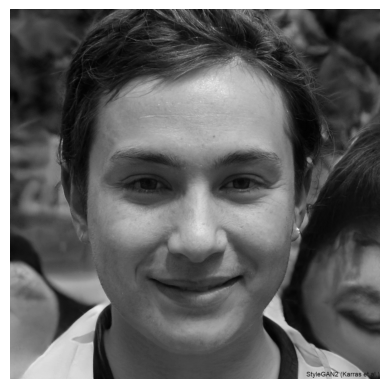

In [ ]:
og_image = cv2.imread(TEST_FILE, 0)  # Exemplo de imagem aleatória
og_image = og_image.astype(np.float32)
show_image(og_image)

In [ ]:
og_image = og_image.astype(np.float32) - 128

In [ ]:
# Constantes importantes para a execução do programa
og_height, og_width = og_image.shape
block_size = 8
og_height, og_width

(1024, 1024)

Os macroblocos nos quais a imagem será dividida possuem *tamanho fixo 8x8*, *conforme descrito acima*. Por isso, caso a imagem possua altura/largura múltipla de 8, adicionamos pixels à direita/embaixo para que ela possua tal propriedade. Esses pixels adicionais são temporários e serão removidos ao final do processo de descompressão.

In [ ]:
height = og_height if og_height % block_size == 0 else (og_height // block_size + 1) * block_size
width = og_width if og_width % block_size == 0 else (og_width // block_size + 1) * block_size
height, width

(1024, 1024)

In [ ]:
# Divisão em macroblocos

macroblocks = divide_into_macroblocks(height, width, block_size)

In [ ]:
image = np.hstack((og_image, np.zeros((og_height, width - og_image.shape[1]))))
image = np.vstack((image, np.zeros((height - image.shape[0], width))))

### Preditive Coding

No contexto do encoding preditivo, as imagens preditas são geradas usando algoritmos que tentam prever um bloco de pixels com base em pixels vizinhos. As predições podem ser feitas de várias maneiras, como predição horizontal (H_PRED), predição vertical (V_PRED), predição de média (DC_PRED), predição de média temporal (TM_PRED), entre outras. Cada uma dessas técnicas de predição tenta estimar os valores dos pixels com base em padrões específicos na imagem.

Nesse algoritmo, para cada macrobloco, é escolhido o padrão de predição que apresenta menor erro.

In [ ]:
predicted_images = { "H_PRED": np.zeros_like(image),
                     "V_PRED": np.zeros_like(image),
                     "DC_PRED": np.zeros_like(image),
                     "TM_PRED": np.zeros_like(image)
                     }

# Produz uma imagem predita usando cada uma das funções de predição
for macroblock_coords in macroblocks:
  y, x = macroblock_coords
  left_column = image[y:y+block_size, max(x-1, 0)]
  above_row = image[max(y-1, 0), x:x+block_size]
  above_left_pixel = image[max(y-1, 0), max(x-1, 0)]
  macroblock = image[y:y+block_size, x:x+block_size]

  prediction_functions = [
      (H_PRED,  [left_column],                             "H_PRED"),
      (V_PRED,  [above_row],                               "V_PRED"),
      (DC_PRED, (above_row, left_column),                  "DC_PRED"),
      (TM_PRED, (above_row, left_column, above_left_pixel),"TM_PRED"),
  ]

  for prediction_function, params, title in prediction_functions:
    pred_block = prediction_function(*params, block_size)
    predicted_images[title][y:y+block_size, x:x+block_size] = pred_block

Temos como exemplo abaixo imagens formadas usando a predição feita por cada função preditiva:

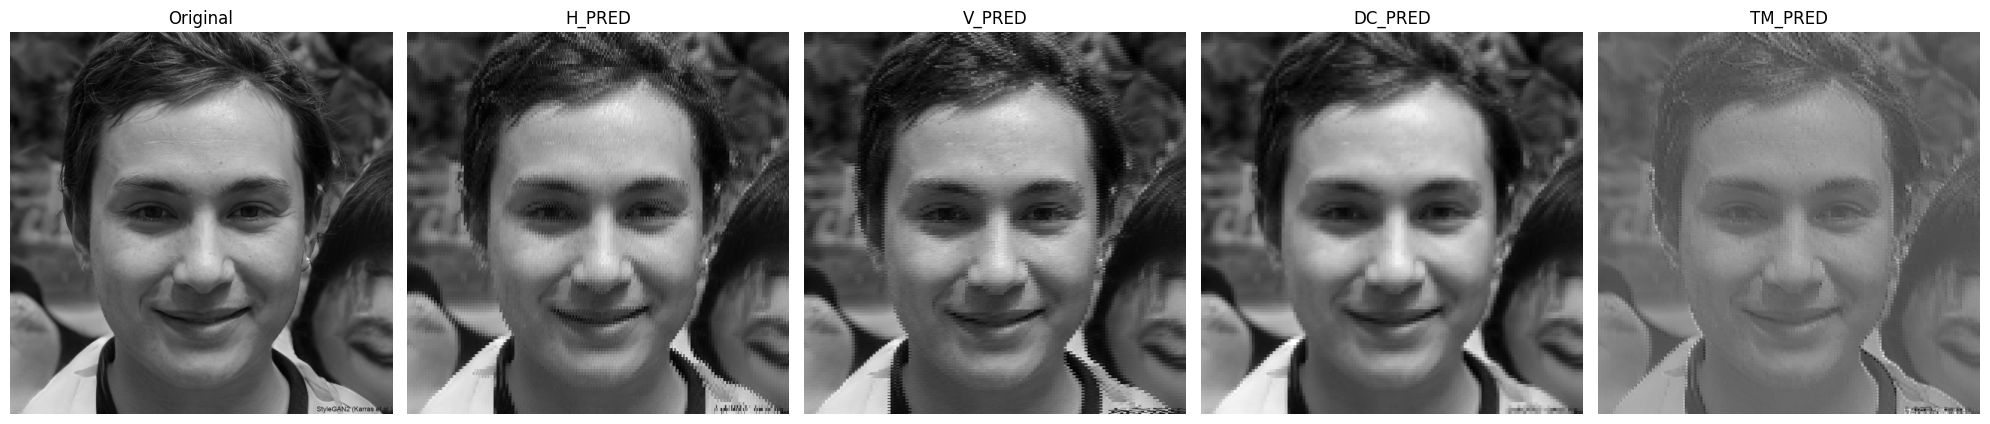

In [ ]:
predicted_images_list = [(title, img) for title, img in predicted_images.items()]

num_predictions = len(predicted_images_list)
plt.figure(figsize=(20, 10))
plt.subplot(1, num_predictions + 1, 1)
show_image(image, 'Original')

# Exibir todas as imagens preditivas
for i, (title, pred_image) in enumerate(predicted_images_list):
    plt.subplot(1, num_predictions + 1, i + 2)
    show_image(pred_image, title)

plt.tight_layout()
plt.show()

Nesse método de compressão, a variância intra-bloco é de grande relevância, especialmente na etapa de quantização. Exibimos abaixo a distribuição da variância dos macroblocos da imagem:


In [ ]:
def calculate_macroblock_variances(image, block_size):
    """Calculate variances of macroblocks."""
    height, width = image.shape[:2]
    macroblock_variances = []

    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            macroblock = image[y:y+block_size, x:x+block_size]
            variance = np.var(macroblock)
            macroblock_variances.append(variance)

    return np.array(macroblock_variances)

# Calculate variances of macroblocks
macroblock_variances = calculate_macroblock_variances(image, block_size)
macroblock_variances = np.sort(macroblock_variances)

Para aplicar o conceito de adaptative quantization, queremos que blocos com alta variância sejam pouco quantizados, e, paralelamente, blocos com baixa variância devem ser penalizados.

Podemos fazer isso com a função

$$f(x) = \frac{1000}{1000 + x}$$


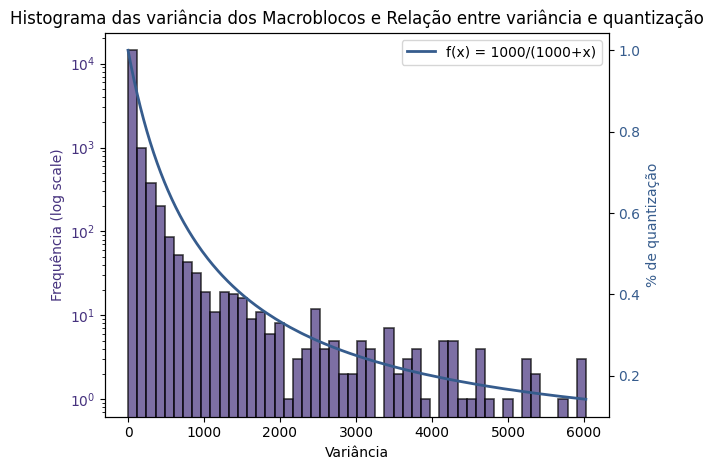

In [ ]:
f = lambda x: 1000 / (1000 + x)

sns.set_palette("viridis")

fig, ax1 = plt.subplots()

color1 = sns.color_palette()[0]
ax1.hist(macroblock_variances,bins=50,  color=color1, alpha=0.7, log=True, label="densidade de cada variância",
         edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Variância')
ax1.set_ylabel('Frequência (log scale)', color=color1)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title('Histograma das variância dos Macroblocos e Relação entre variância e quantização')

ax2 = ax1.twinx()
color2 = sns.color_palette()[1]
ax2.plot(macroblock_variances, f(macroblock_variances), color=color2, label="f(x) = 1000/(1000+x)",
         linewidth=2)
ax2.set_ylabel('% de quantização', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.legend()
plt.show()

O histograma das variações dos macroblocos nos fornece informações sobre a distribuição dos detalhes na imagem. Com base nessa distribuição, podemos selecionar thresholds apropriados para a quantização. Esses thresholds determinam a quantidade de detalhes que serão preservados ou descartados durante a compressão da imagem

Discretizando a função temos:

In [ ]:
parts = np.linspace(0, 1, 256)

### Aplicação do Algoritmo Webp

In [ ]:
reconstructed_image = reconstruct_image([], height, width, block_size)

pre_encoded = []
residuals = []
predictions = []
originals = []
values = {
    "height": height,
    "width": width,
    'block size': block_size,
    'best prediction function': [],
    'quantization step': [],
    'codes': []
}
codes = []

encoder = ShannonFano()

In [ ]:
# Realizamos a compressão de cada macrobloco
for macroblock_coords in tqdm(macroblocks):
  y, x = macroblock_coords
  macroblock = image[y:y+block_size, x:x+block_size]
  # Predição
  predicted_macroblock,(best_prediction_function,_)  = predict_pixel(x,y,macroblock,reconstructed_image, block_size=block_size)
  predictions.append(predicted_macroblock)

  # Cálculo dos resíduos
  macroblock_residuals = compute_residuals(macroblock, predicted_macroblock)
  residuals.append(macroblock_residuals)

  # Transformação e quantização
  transformed_residuals = transform_coding_dct(macroblock_residuals)
  quantized_transformed_residuals, quantization_step = quantization(transformed_residuals, quantization_matrix)


  """
  Nesse momento, a imagem transformada já foi calculada
  Entretanto, para que o preditive encoding funcione
  precisamos que cada macrobloco seja dequantizado e reconstruído
  já que o macrobloco atual vai ser usado para fazer a previsão do próximo
  """
  original = decode_block(quantized_transformed_residuals, parts[quantization_step], x, y, reconstructed_image, best_prediction_function, block_size)
  originals.append(original)
  reconstructed_image[y:y+block_size, x:x+block_size] = original

  # Armazenamento
  pre_encoded.append(quantized_transformed_residuals)
  values['best prediction function'].append(best_prediction_function)
  values['quantization step'].append(quantization_step)

100%|██████████| 16384/16384 [00:18<00:00, 866.15it/s] 


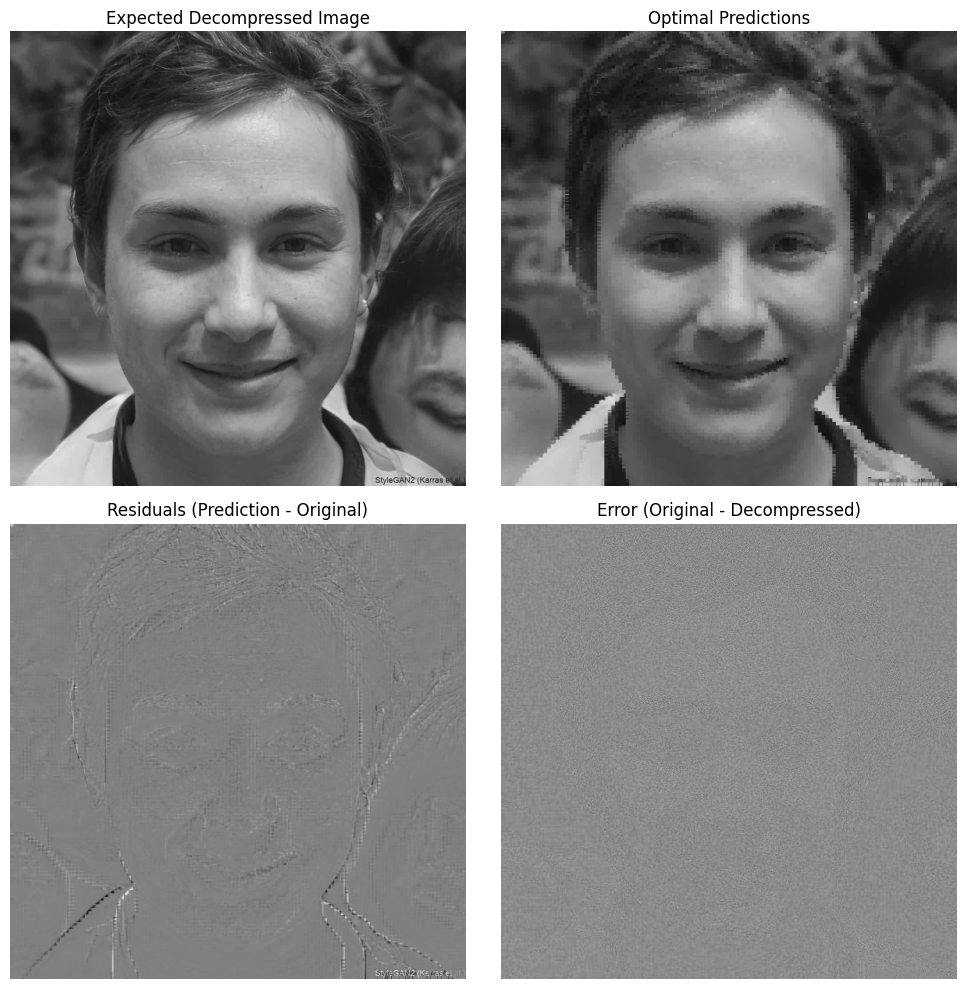

In [ ]:
reconstructed_prediction = reconstruct_image(predictions, height, width, block_size)
reconstructed_residuals = reconstruct_image(residuals, height, width, block_size)
compressed = reconstruct_image(originals, height, width, block_size)
error = image - compressed

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].imshow(compressed, cmap='gray')
axs[0][0].set_title('Expected Decompressed Image')
axs[0][0].axis('off')


axs[0][1].imshow(reconstructed_prediction, cmap='gray')
axs[0][1].set_title('Optimal Predictions')
axs[0][1].axis('off')

axs[1][0].imshow(reconstructed_residuals, cmap='gray')
axs[1][0].set_title('Residuals (Prediction - Original)')
axs[1][0].axis('off')


axs[1][1].imshow(error, cmap='gray')
axs[1][1].set_title('Error (Original - Decompressed)')
axs[1][1].axis('off')


plt.tight_layout()
plt.show()

### Codificação da imagem resultante

In [ ]:
# Exemplo da utilização da função de zigzag para vetorização da matriz.

A = np.array([[ 0,  1,  2,  3, 4],
              [ 5,  6,  7,  8, 9],
              [ 10,  11, 12, 13, 14],
              [15, 16, 17, 18, 19],])

B = zigzag(A)
print("Zigzagged array:", B)

C = (undo_zigzag(B, (A.shape[0], A.shape[1])))
print("Reconstructed matrix:\n", C)

Zigzagged array: [ 0.  5.  1.  2.  6. 10. 15. 11.  7.  3.  4.  8. 12. 16. 17. 13.  9. 14.
 18. 19.]
Reconstructed matrix:
 [[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]]


In [ ]:
pre_encoded_img = reconstruct_image(pre_encoded, height, width, block_size)

In [ ]:
# Codificação
encoder = ShannonFano()
encoded_img, values["codes"] = encoder.encode(pre_encoded_img, ndim=2)

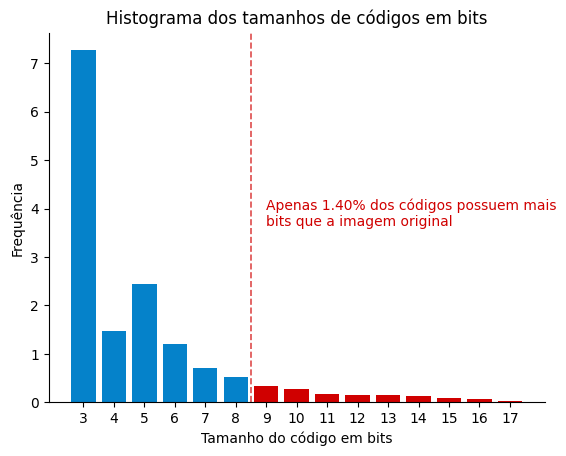

In [ ]:
codigos = [len(p) for p in encoded_img]
overgrow = len([c for c in codigos if c > 8])
c = Counter(codigos)

# Define RGB colors for bars
colors = [(5/255, 130/255, 202/255) if key <= 8 else (208/255, 0/255, 0/255) for key in c.keys()]  # Red for > 8, Blue for <= 8

# Create the bar plot
x = c.keys()
y = np.array(list(c.values()))
bars = plt.bar(c.keys(), y/np.mean(y), color=colors)
y_max = max([b.get_height() for b in bars])


plt.text(9, y_max/2, f'Apenas {overgrow/np.mean(y):.2f}% dos códigos possuem mais\nbits que a imagem original', color=(208/255, 0/255, 0/255))
plt.axvline(x=8.5, ymin=0, ymax=1, color=(208/255, 0/255, 0/255), linestyle='--', alpha=0.7,lw=1.2)

# Add labels to the bars
plt.xticks(list(c.keys()))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Histograma dos tamanhos de códigos em bits")
plt.xlabel("Tamanho do código em bits")
plt.ylabel("Frequência")
plt.show()


### Escrita do arquivo binário

Armazenamos o cabeçalho juntamente com a imagem codificada em uma única cadeia de bits no arquivo de destino.

In [ ]:
to_bits = lambda x,y: "{0:b}".format(x).zfill(y)
bitstr = ""

In [ ]:
# Armazena o cabeçalho

# height    (16 bits)
bitstr += to_bits(height,16)
# width     (16 bits)
bitstr += to_bits(width,16)

# original height (16 bits)
bitstr += to_bits(og_height, 16)
# original width  (16 bits)
bitstr += to_bits(og_width, 16)

# Indexes (2 bits)
for p in values['best prediction function']:
  bitstr += to_bits(p,2)

# Quantization Steps (8 bits)
for p in values['quantization step']:
  bitstr += to_bits(p,8)

In [ ]:
# Armazena a imagem codificada

bitstr += ''.join(encoded_img)
bitarr = bitarray(bitstr)
bitstr[-20:]

'11000001111101101001'

In [ ]:
with open('image.bin', 'wb') as f:
  pickle.dump(values["codes"], f)
  pickle.dump(bitarr, f)
os.path.getsize('image.bin')

105843

In [ ]:
og_size = os.path.getsize(TEST_FILE)
compressed_size = os.path.getsize('image.bin')
print(f'Tamanho do arquivo comprimido: {compressed_size:_}')
print(f'Tamanho da imagem original: {og_size:_}')
print('Taxa de compressão: %5.3f' % (og_size/compressed_size))

Tamanho do arquivo comprimido: 105_843
Tamanho da imagem original: 537_291
Taxa de compressão: 5.076


## Descompressão


Inicialmente, realizamos o comportamento inverso para obter as informações a partir da cadeia de bits. Primeiramente, obtemos os valores do cabeçalho, e posteriormente a imagem codificada.

In [ ]:
with open('image.bin', 'rb') as f:
  codes = pickle.load(f)
  bitarr= pickle.load(f).to01()

In [ ]:
# Obtém o cabeçalho

index = 0

# Decode height (16 bits)
height = int(bitarr[index:index+16], 2)
index += 16

# Decode width (16 bits)
width = int(bitarr[index:index+16], 2)
index += 16

# Decode original height (16 bits)
og_height = int(bitarr[index:index+16], 2)
index += 16

# Decode original width (16 bits)
og_width = int(bitarr[index:index+16], 2)
index += 16

n_blocks = len(divide_into_macroblocks(height, width, block_size))

# Decode best prediction function (2 bits * n_blocks)
best_prediction_function = []
for i in range(n_blocks):
   best_prediction_function.append(int(bitarr[index:index+2], 2))
   index += 2

# Decode quantization steps function (8 bits * n_blocks)
quantization_steps = []
for i in range(n_blocks):
   quantization_steps.append(int(bitarr[index:index+8], 2))
   index += 8

print(height,width)

1024 1024


Devido à propriedade que nenhum código é prefixo de outro, para obter os símbolos originais a partir dos blocos podemos iterar pela cadeia. Quando encontrarmos uma substring que corresponde a um código, a substituímos pelo símbolo original e continuamos o processo do próximo bit.

In [ ]:
encoded_img = []
while index != len(bitarr):
  curr = ""
  while(curr not in codes):
    curr += bitarr[index]
    index += 1
  encoded_img.append(curr)

In [ ]:
quantization_steps =  [parts[p] for p in quantization_steps]

In [ ]:
# Decode
encoder = ShannonFano()
decoded_img = encoder.decode(encoded_img, codes, height, width)

In [ ]:
decompress = []

reconstructed_image = reconstruct_image([], height, width, block_size)

for (macroblocks_coord,pred_idx,step) in tqdm(zip(macroblocks,best_prediction_function,quantization_steps)):
  y, x = macroblocks_coord
  macroblock = decoded_img[y:y+block_size, x:x+block_size]

  original = decode_block(macroblock, step, x, y, reconstructed_image, pred_idx, block_size)

  reconstructed_image[y:y+block_size, x:x+block_size] = original
  decompress.append(original.round().astype(float))

reconstructed_image += 128

16384it [00:01, 14641.08it/s]


In [ ]:
# Remove colunas e linhas para que a imagem recupere seu tamanho original
height_diff = int(height) - int(og_height)
width_diff = int(width) - int(og_width)

if height_diff > 0:
    reconstructed_image = reconstructed_image[: -height_diff]

if width_diff > 0:
    reconstructed_image = reconstructed_image[:, : -width_diff]

In [ ]:
print(height, width)
print(og_height, og_width)

1024 1024
1024 1024


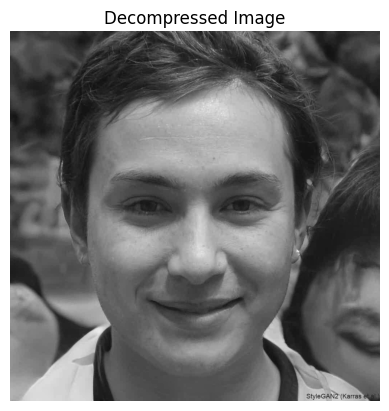

In [ ]:
show_image(reconstructed_image, 'Decompressed Image')

In [ ]:
reconstructed_image.shape

(1024, 1024)

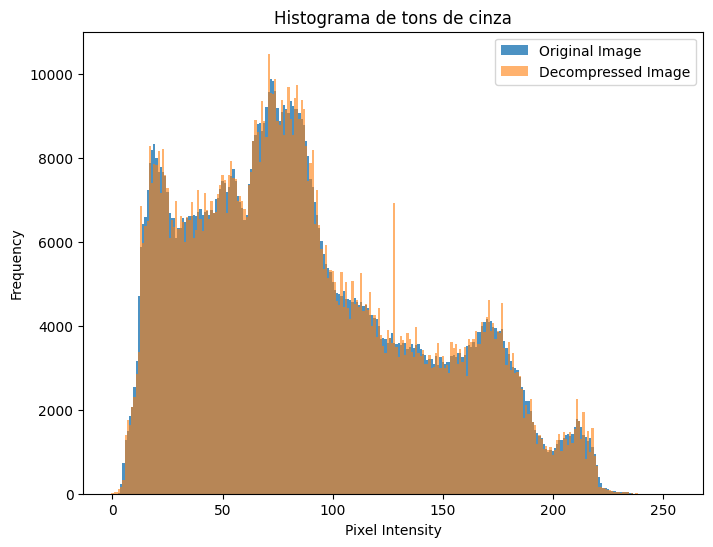

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_palette("tab10")


hist, bins = np.histogram(og_image.flatten() + 128, bins=256, range=(0, 256))
plt.bar(bins[:-1], hist, width=1, alpha=0.8,label="Original Image")

hist, bins = np.histogram(reconstructed_image.flatten(), bins=256, range=(0, 256))
plt.bar(bins[:-1], hist, width=1, alpha=0.6,label="Decompressed Image")


plt.title('Histograma de tons de cinza')
plt.xlabel('Pixel Intensity')

plt.ylabel('Frequency')
plt.legend()
plt.show()

## Resultado final

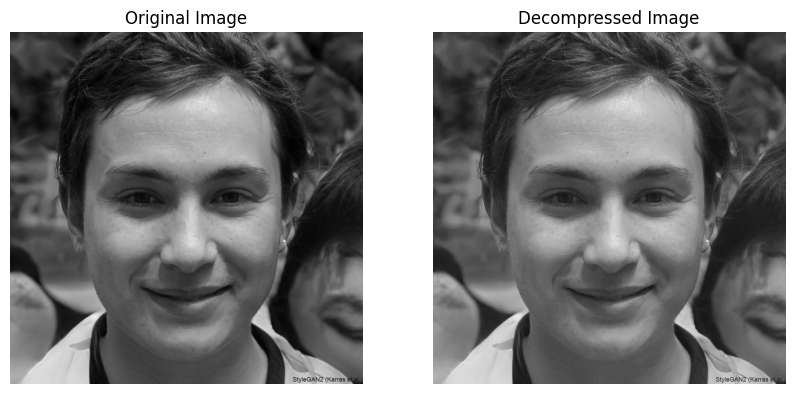

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.imshow(og_image + 128, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Decompressed Image')
plt.axis('off')

plt.show()


In [ ]:
print ("RMSE: %5.3f" % rmse(og_image + 128, reconstructed_image))
print ("PSNR: %5.3f" % psnr(og_image + 128, reconstructed_image))

RMSE: 3.222
PSNR: 37.968


In [ ]:
og_size = os.path.getsize(TEST_FILE)
compressed_size = os.path.getsize('image.bin')
print(f'Tamanho do arquivo comprimido: {compressed_size:_}')
print(f'Tamanho da imagem original: {og_size:_}')
print('Taxa de compressão: %5.3f' % (og_size/compressed_size))

Tamanho do arquivo comprimido: 105_843
Tamanho da imagem original: 537_291
Taxa de compressão: 5.076


In [ ]:
from scipy.stats import entropy

def calcEntropy(img):
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    hist = hist / hist.sum()
    return entropy(hist, base=2)

ent = calcEntropy(image)

In [ ]:
bits = [len(code) for code in encoded_img]
nbits = np.sum(bits)
bpp = nbits/len(bits)

In [ ]:
print ("\nSummary:")
print ("Entropia da Imagem: %5.3f" % ent)
print ("Tamanho: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel" % bpp)
print ("Eficiência de codificação: %5.3f" % (ent/bpp))
print ("Taxa de compressão (sem o header): %5.3f" % (8/bpp))
print ("RMSE: %5.3f" % rmse(og_image + 128, reconstructed_image))
print ("PSNR: %5.3f" % psnr(og_image + 128, reconstructed_image))


Summary:
Entropia da Imagem: 6.455
Tamanho: 46058 bytes
4.819 bits/pixel
Eficiência de codificação: 1.340
Taxa de compressão (sem o header): 1.660
RMSE: 3.222
PSNR: 37.968
